## Again, load up the libraries and data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot
import os
import re

## here we'll set the matplotlib figure size to take up more real estate
pyplot.rcParams['figure.figsize'] = [12, 5]

outputFiles = os.listdir('./output')
output_series = (list(), list())
output_metrics = (list(), list())
inputs = (list(), list())
for outputFile in outputFiles:
    simName = outputFile[:outputFile.index('.output')]
    with open("./output/" + outputFile, 'r') as f:
        for cnt, line in enumerate(f):
            split = line.split()
            if len(split) > 1:
                if split[0].startswith('OUT'):
                    measure = split[0][:split[0].rfind('_')]
                    iteration = int(split[0][split[0].rfind('_')+1:])
                    if len(split) > 2:
                        output_series[0].append((simName, measure, iteration))
                        output_series[1].append(pd.Series(split[1:]).astype(float))
                    else:
                        output_metrics[0].append((simName, measure, iteration))
                        output_metrics[1].append(float(split[1]))
                        
                if split[0].startswith('INP'):
                    inputs[0].append((simName, split[0]))
                    inputs[1].append(float(split[1]))
                                   
series_index = pd.MultiIndex.from_tuples(output_series[0], names=['simulation', 'measure', 'iteration'])
series = pd.DataFrame(pd.Series(output_series[1], index=series_index), columns=['values'])

metrics_index = pd.MultiIndex.from_tuples(output_metrics[0], names=['simulation', 'measure', 'iteration'])
metrics = pd.DataFrame(pd.Series(output_metrics[1], index=metrics_index), columns=['values'])

inputs_index = pd.MultiIndex.from_tuples(inputs[0], names=['simulation', 'measure'])
inputs = pd.DataFrame(pd.Series(inputs[1], index=inputs_index), columns=['values'])


## We'll count the number of iterations with mean wait times of < 15 minutes for each simulation

In [17]:
series = series.reset_index()
series.set_index(['measure', 'simulation', 'iteration'], inplace=True)
mean_waits = pd.DataFrame(series['values']['OUT_CUSTOMER_WAIT_TIMES'].apply(lambda x: x.mean()))
mean_waits.loc[mean_waits['values'] < 15].groupby('simulation').count()

,values
simulation,
cashier_1000_12,38
cashier_1000_13,65
cashier_1000_14,83
cashier_1000_15,82
cashier_1000_16,86


## It looks like the sweet spot is between 14 and 16 cashiers. The three of them produce wait times less than 15 minutes 90% of the time or better.
---
## Lets look at the mean wait times for these three simulations. 

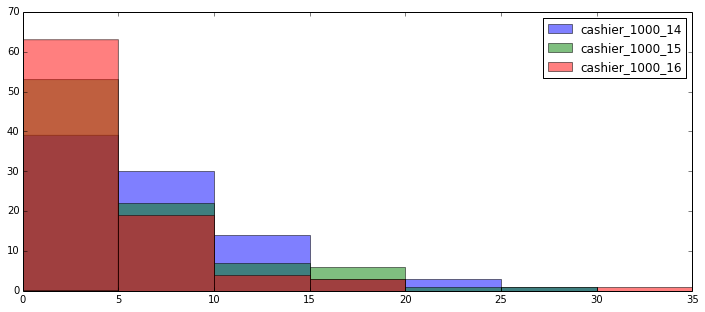

In [11]:
wait_mean_14 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_14'].apply(lambda x: x.mean())
wait_mean_15 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_15'].apply(lambda x: x.mean())
wait_mean_16 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_16'].apply(lambda x: x.mean())

bins = range(0, 40, 5)
pyplot.hist(wait_mean_14, alpha=0.5, label='cashier_1000_14', bins=bins)
pyplot.hist(wait_mean_15, alpha=0.5, label='cashier_1000_15', bins=bins)
pyplot.hist(wait_mean_16, alpha=0.5, label='cashier_1000_16', bins=bins)
pyplot.legend(loc='upper right')
pyplot.show()

## Here we see what we would expect. 16 cashiers perform the best, providing an average wait time of < 5 minutes ~ 62% of the time, compared to 52% for 15 cashiers and 38% for 14 cashiers. We also see that 14 cashiers perform poorly rendering the most mean wait times above 10 minutes.
---
##  Let's focus on the 15 & 16 cashier simulations. This will be a little wonky, but lets take a look at the distributions of the 90th percentile of the wait times.

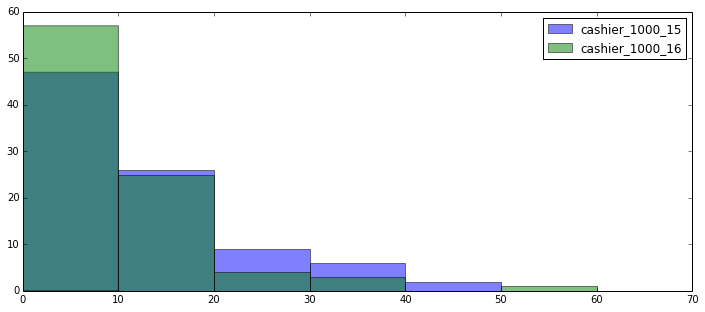

In [13]:
wait_90_quantile_15 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_15'].apply(lambda x: x.quantile(0.90))
wait_90_quantile_16 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_16'].apply(lambda x: x.quantile(0.90))

bins = range(0, 80, 10)
pyplot.hist(wait_90_quantile_15, alpha=0.5, label='cashier_1000_15', bins=bins)
pyplot.hist(wait_90_quantile_16, alpha=0.5, label='cashier_1000_16', bins=bins)
pyplot.legend(loc='upper right')
pyplot.show()

## The 90th percentile for 16 cashiers have a wait time of < 10 minutes ~ 56 out of 90. These two simulations have similar percentile distributions. 
---
## Let's see how the cashier idle times compare.

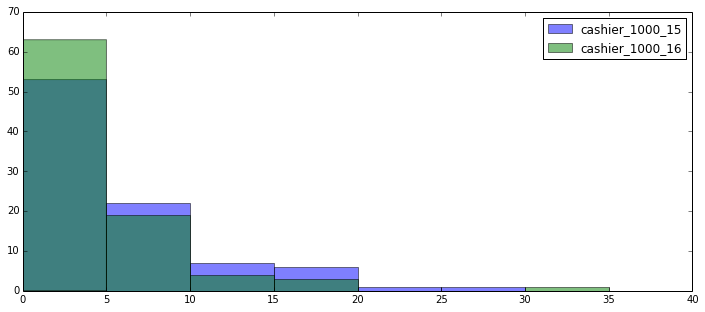

In [18]:
idle_mean_15 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_15'].apply(lambda x: x.mean())
idle_mean_16 = series['values']['OUT_CUSTOMER_WAIT_TIMES']['cashier_1000_16'].apply(lambda x: x.mean())

bins = range(0, 45, 5)
pyplot.hist(idle_mean_15, alpha=0.5, label='cashier_1000_15', bins=bins)
pyplot.hist(idle_mean_16, alpha=0.5, label='cashier_1000_16', bins=bins)
pyplot.legend(loc='upper right')
pyplot.show() 

## The mean idle times are also very similar. Depending on the business's tolerance for wait times above twenty minutes, 15 cashiers may be the way to go.